# Preprocessing and correcting sinograms
### **A Tutorial on sinogram handling**

## **Overview**
This tutorial introduces the key **sinogram preprocessing functions** in `nDTomo`, designed to handle raw pencil beam CT data before reconstruction. Preprocessing is essential to correct for experimental artefacts such as baseline offsets, beam intensity fluctuations, misalignment, and center of rotation drift — all of which can severely degrade the quality of the reconstructed image.

These tools operate on both **2D sinograms** and **3D sinogram stacks** (e.g., spectral or z-resolved data), and are modular so you can tailor your preprocessing pipeline to your specific dataset and experimental setup.

## **Objectives**
By the end of this tutorial, you will:
- Apply `nDTomo` functions to correct **background offsets**, **beam drift**, **motor jitter**, and **rotation misalignment**.
- Understand how each function transforms the sinogram and why it’s necessary.
- Build a robust preprocessing workflow for high-quality tomographic reconstruction.

## **Sinogram Preprocessing Functions**

### **1. `airrem` – Air Background Removal**
Removes additive background signal (air signal) by estimating and subtracting it from edge rows of the sinogram. This is useful when portions of the sinogram (top/bottom) contain no sample.

- **Modes**: `"both"`, `"top"`, `"bottom"` — determines where to sample air signal
- **Offset (`ofs`)**: Number of rows used to estimate the background
- **Column selection (`coli`, `colf`)**: Restrict estimation to specific columns
- **Supports**: 2D and 3D sinograms (correction applied per projection)

**Why use it?**  
To suppress air-related background levels that would otherwise interfere with reconstruction or downstream fitting.

### **2. `scalesinos` – Sinogram Normalization**
Normalizes each projection by its total integrated intensity to account for fluctuations in beam intensity or sample attenuation.

- Computes a **scaling factor per projection**
- Divides each projection to normalize its sum relative to the maximum
- Automatically handles 2D and 3D sinograms

**Why use it?**  
To equalize projection contributions and reduce artefacts from flux instability, detector gain drift, or sample thickness variations.

### **3. `sinocomcor` – Common-Mode Correction / Motor Jitter Correction**
Aligns projections based on their **center of mass** (COM), compensating for scan motor jitter or random translation shifts.

- Uses the COM of each projection
- Shifts projections using linear interpolation
- Works for 2D and 3D sinograms

**Why use it?**  
To correct for lateral misalignments between projections caused by motor jitter or detector drift, improving reconstruction sharpness.

### **4. `sinocentering` – Center of Rotation (COR) Alignment**
Identifies and corrects the **center of rotation offset** by comparing projections at 0° and 180°.

- Searches for COR by minimizing the standard deviation of flipped projections
- Works with 180° or 360° scans
- Optionally selects spectral channels to use
- Applies correction using interpolation
- Supports 2D and 3D inputs

**Why use it?**  
To ensure the reconstructed image is centered and symmetric. Misaligned rotation axes produce severe artefacts and incorrect geometries.

## **How This Tutorial Works**
- We begin with a raw sinogram or stack of sinograms.
- Each preprocessing step is visualized to show its effect.
- Intermediate results are plotted after each correction.
- The final output is a clean, centered, and normalized sinogram ready for reconstruction (e.g., via filtered backprojection or DLSR).

## **Why This Matters**
- Preprocessing directly impacts the **fidelity of tomographic reconstructions**
- Many artefacts (e.g., ringing, misalignments, loss of contrast) can be traced back to poor sinogram conditioning
- These tools provide a **physically informed, user-adjustable**, and lightweight preprocessing pipeline for pencil beam CT

Let’s now apply each of these functions in sequence and observe their effects.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import iradon, radon

from nDTomo.sim.phantoms import SheppLogan

First we create a phantom object that we will use for our simulations

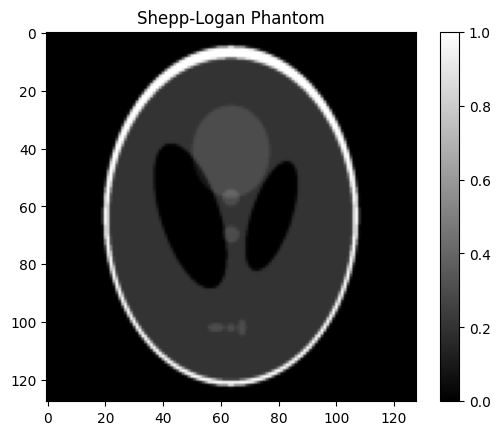

In [11]:
npix = 128
img = SheppLogan(npix)

plt.figure(1);plt.clf()
plt.imshow(img, cmap='gray')
plt.title('Shepp-Logan Phantom')
plt.colorbar()
plt.show()


The number of angles is 128


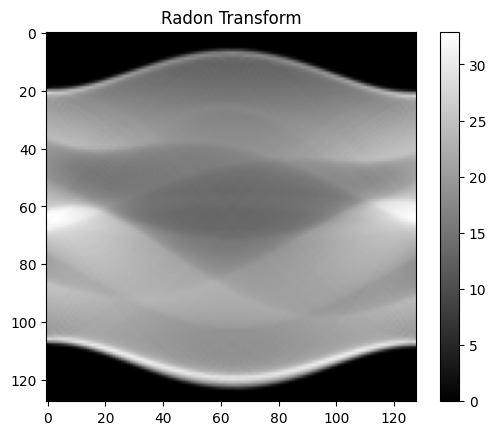

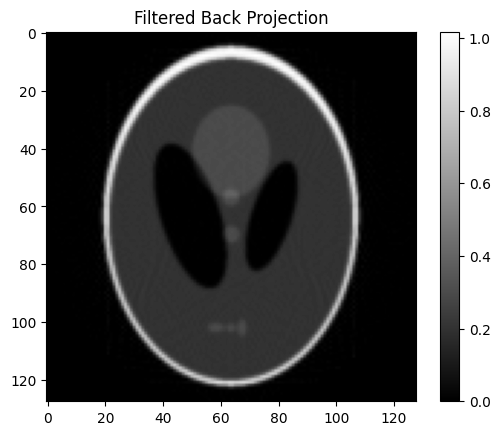

In [10]:
scan = 180
theta = np.arange(0, scan, scan/npix) 
print('The number of angles is', len(theta))

s = radon(img, theta) 

fbp = iradon(s, theta, filter_name='ramp', output_size=npix)
fbp[fbp < 0] = 0    

plt.figure(1);plt.clf()
plt.imshow(s, cmap='gray')
plt.title('Radon Transform')
plt.colorbar()
plt.show()

plt.figure(2);plt.clf()
plt.imshow(fbp, cmap='gray')
plt.title('Filtered Back Projection')
plt.colorbar()
plt.show()


scalesinos

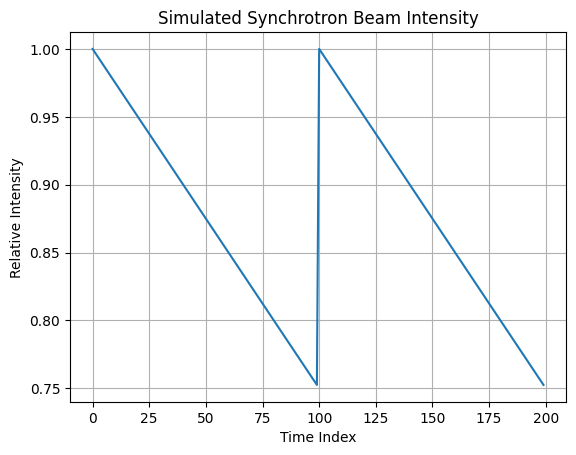

In [ ]:
def simulate_synchrotron_intensity(num_points, drop_ratio=0.75, num_topups=1):
    """
    Simulate synchrotron beam intensity with linear decay and periodic top-ups.

    Parameters
    ----------
    num_points : int
        Total number of points in the output array.
    drop_ratio : float
        Intensity level just before each top-up (e.g., 0.75).
    num_topups : int
        Number of top-up events (i.e., decay cycles) in the vector.

    Returns
    -------
    intensity : np.ndarray
        Simulated beam intensity values over time.
    """
    if num_topups < 1:
        raise ValueError("num_topups must be at least 1.")
    
    points_per_cycle = num_points // num_topups
    decay = np.linspace(1.0, drop_ratio, points_per_cycle, endpoint=False)

    # Repeat decay cycles
    intensity = np.tile(decay, num_topups)

    # Pad remaining points if needed
    remainder = num_points - len(intensity)
    if remainder > 0:
        last_cycle = np.linspace(1.0, drop_ratio, points_per_cycle, endpoint=False)
        intensity = np.concatenate([intensity, last_cycle[:remainder]])

    return intensity

sf = simulate_synchrotron_intensity(200, 0.75, num_topups=2)

plt.figure(3);plt.clf()
plt.plot(sf)
plt.title("Simulated Synchrotron Beam Intensity")
plt.xlabel("Time Index")
plt.ylabel("Relative Intensity")
plt.grid(True)
plt.show()


In [ ]:
sn = np.copy(s)

for ii in range(1, int(sn.shape[1]/2)):
    sn[:, ii] = sn[:, ii] * np.

fbp = iradon(sn, theta, filter_name='ramp', output_size=npix)
fbp[fbp < 0] = 0    

plt.figure(1);plt.clf()
plt.imshow(sn, cmap='gray')
plt.title('Radon Transform')
plt.colorbar()
plt.show()

plt.figure(2);plt.clf()
plt.imshow(fbp, cmap='gray')
plt.title('Filtered Back Projection')
plt.colorbar()
plt.show()